# THESIS NOTEBOOK - infer.py

### Libraries are imported here:

In [1]:
import numpy as np
import pandas as pd
from PIL import Image

import caffe
import vis

# own libraries
import colorgram
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import random
import shutil
import time
import datetime
import math
import sys
import re

import score
import voc_layers

# sklearn libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# matplot libraries
import matplotlib.pyplot as plt

# graphviz library - visualization of trees library
import graphviz

# ast library- used to convert string expressions to python expressions
import ast

# for bell sound
import subprocess

### Constant and global variables:

In [2]:
# own code - Jasper
PRINT_SECONDS = 0 # 0.2
REVIEW_SECONDS = 0 # 5
REST_SECONDS = 0 # 10
ERROR_ABOVE = "Image {height, width} has above 1000 pixels"
PASS_BELOW = "Image {height, width} has below 1000 pixels"
OUTPUT_FOLDER = "output_score" # no slashes both first and last
OUTPUT_FOLDER_VALIDATION = "output_validate"
dm = "" # global dimensions string
JPG_FILETYPE = ".jpg"
PNG_FILETYPE = ".png"
loss = 0
over_acc_scores = []
mean_acc_scores = []
iu_scores = []
freq_scores = []
session_count = 0
plot = 0 # initialize plot for global use
n = 0 # initialize number of paintings for global use
LIMIT_X = 4 # limit columns for figure
labels = [] # labels for the confusion_matrix_board (x and y axis)
figsize = (30, 20)

### Function section here:

#### trackSession

In [3]:
def trackSession():
    global session_count
    if session_count == 0:
        session_count += 1
        return True
    else:
        return False
    return False

#### setSession

In [4]:
def setSession(file, flag=True):
    now = datetime.datetime.now()
    if flag:
        file.write("\n-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))
    else:
        file.write("-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))

#### endSession

In [5]:
def endSession(flag=True):
    now = datetime.datetime.now()
    if flag:
        return "\n-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    else:
        return "-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    return ""

#### delayPrint

In [6]:
def delayPrint(string, seconds): # n seconds delay printing
    time.sleep(seconds)
    exportLogs(string)
    print(string)

#### getPaintings

In [7]:
def getPaintings(path):
    paintings = [f.split(JPG_FILETYPE)[0] for f in listdir(path) if isfile(join(path, f))] # splits only for .jpg images
    paintings.sort()
    return paintings

#### getLabels

In [8]:
def getLabels(path):
    paintings = [f.split(PNG_FILETYPE)[0] for f in listdir(path) if isfile(join(path, f))] # splits only for .png images
    paintings.sort()
    return paintings

#### exportLogs

In [9]:
def exportLogs(logs, f="demo/logs.log"):
    logs += "\n"
    if(isfile(f)):
        file = open(f, "a")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()
    else:
        print("Log file does not exist!")
        print("Creating {} file...".format(f))
        file = open(f, "a+")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()

#### createCurrentLog

In [10]:
def createCurrentLog(fp, output_folder=OUTPUT_FOLDER):
    filepath = fp.split("/")
    f = "demo/{}/{}.log".format(output_folder, filepath[len(filepath) - 1].split(JPG_FILETYPE)[0])
    if(isfile(f)):
        delayPrint("Resuming {} file".format(f), PRINT_SECONDS)
        file = open(f, "w")
        setSession(file, False)
        file.close()
    else:
        print("{} log file does not exist!".format(f))
        print("Creating {} file...".format(f))
        file = open(f, "w+")
        setSession(file, False)
        file.close()

#### readResume

In [11]:
def readResume(f="demo/resume.txt"):
    fp_resume = ""
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "r")
        delayPrint("Reading file...", PRINT_SECONDS)
        fp_resume = file.read()
        delayPrint("Last segmented image: {}".format(fp_resume.rstrip()), PRINT_SECONDS)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)
    return fp_resume

#### writeResume

In [12]:
def writeResume(current_painting_path, f="demo/resume.txt"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "w+")
        delayPrint("Saving last segmented image path...", PRINT_SECONDS)
        delayPrint("Writing file...", PRINT_SECONDS)
        file.write(current_painting_path)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)

#### writeErrorFile

In [13]:
def writeErrorFile(current_painting_path, error="", f="demo/error.log"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "a")
        delayPrint("Writing error file...", PRINT_SECONDS)
        file.write("{} - {}\n".format(current_painting_path, error))
        delayPrint("Closing error file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("{} log file does not exist!".format(f), PRINT_SECONDS)
        delayPrint("Creating {} file...".format(f), PRINT_SECONDS)
        delayPrint("Writing error file...", PRINT_SECONDS)
        file = open(f, "a+")
        file.write("{} - {}\n".format(current_painting_path, error))
        delayPrint("Closing error file...", PRINT_SECONDS)
        file.close()

#### writeListOfPaintings

In [ ]:
def writeListOfPaintings(lop, f="demo/list_of_paintings.txt"):
    with open(f, "w+") as file:
        delayPrint("Writing list of paintings to {}".format(f), PRINT_SECONDS)
        file.write("{}".format(lop))

#### reshapeInputLayer

In [14]:
def reshapeInputLayer(img, LINE_NUMBER=7, f="voc-fcn8s/test.prototxt"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    # LINE_NUMBER = 7
    width, height = img.size
    if(isfile(f)):
        with open(f, "r") as file:
            delayPrint("Reading file...", PRINT_SECONDS)
            data = file.readlines()
            delayPrint("Reshaping input layer...", PRINT_SECONDS)
            data[LINE_NUMBER] = "    shape { dim: 1 dim: 3 dim: %s dim: %s }\n"%(height, width)
            delayPrint(data[LINE_NUMBER], PRINT_SECONDS)
        with open(f, "w+") as file:
            delayPrint("Writing file...", PRINT_SECONDS)
            file.writelines(data)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)

#### reshapeLabelLayer

In [15]:
def reshapeLabelLayer(img, LINE_NUMBER=7, f="voc-fcn8s/test.prototxt"):
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    # LINE_NUMBER = 7
    width, height = img.size
    if(isfile(f)):
        with open(f, "r") as file:
            delayPrint("Reading file...", PRINT_SECONDS)
            data = file.readlines()
            delayPrint("Reshaping label layer...", PRINT_SECONDS)
            data[LINE_NUMBER] = "    shape { dim: 1 dim: %s dim: %s }\n"%(height, width)
            delayPrint(data[LINE_NUMBER], PRINT_SECONDS)
        with open(f, "w+") as file:
            delayPrint("Writing file...", PRINT_SECONDS)
            file.writelines(data)
        delayPrint("Closing file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("File does not exist!", PRINT_SECONDS)

#### checkImageSize1000000

In [16]:
def checkImageSize1000000(img):
    delayPrint("Checking if image {width, height} has 1,000,000 and above pixels...", PRINT_SECONDS)
    width, height = img.size
    dimensions = " - ({} x {})".format(height, width)
    global dm
    dm = dimensions
    ONE_MIL = 1000000
    delayPrint("Images (H x W) has dimensions {} x {}".format(height, width), PRINT_SECONDS)
    if((width * height) >= ONE_MIL):
        delayPrint(ERROR_ABOVE+dimensions, PRINT_SECONDS)
        return True
    else:
        delayPrint(PASS_BELOW+dimensions, PRINT_SECONDS)
        return False
    return False

#### validationResultsLog

In [17]:
def validationResultsLog(current_painting_path, results, f="demo/results.log"):
    global loss
    global over_acc_scores
    global mean_acc_scores
    global iu_scores
    global freq_scores
    labels = ["Overall accuracy", "Mean accuracy", "Mean IU", "Fwavacc accuracy"]
    initValidationScores(labels) # initialize file first
    labels, scores = getValidationScores()
    over_acc_scores = scores[0]
    mean_acc_scores = scores[1]
    iu_scores = scores[2]
    freq_scores = scores[3]
    loss += results['loss']
    over_acc_scores.append(results['over_acc'])
    mean_acc_scores.append(results['mean_acc'])
    iu_scores.append(results['iu'])
    freq_scores.append(results['freq'])
    scores = [results['over_acc'], results['mean_acc'], results['iu'], results['freq']]
    labels = ["Overall accuracy", "Mean accuracy", "Mean IU", "Fwavacc accuracy"]
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "a")
        delayPrint("Writing results file...", PRINT_SECONDS)
        file.write("{}\n".format(current_painting_path))
        file.write("\t\tLoss: {}\n".format(results['loss']))
        if len(scores) == len(labels):
            for x in range(len(labels)):
                file.write("\t\t{}: {}\n".format(labels[x], scores[x]))
        file.write("\n")
        delayPrint("Closing results file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("{} log file does not exist!".format(f), PRINT_SECONDS)
        delayPrint("Creating {} file...".format(f), PRINT_SECONDS)
        delayPrint("Writing results file...", PRINT_SECONDS)
        file = open(f, "a+")
        file.write("{}\n".format(current_painting_path))
        file.write("\t\tLoss: {}\n".format(results['loss']))
        if len(scores) == len(labels):
            for x in range(len(labels)):
                file.write("\t\t{}: {}\n".format(labels[x], scores[x]))
        file.write("\n")
        delayPrint("Closing results file...", PRINT_SECONDS)
        file.close()
    scores = [over_acc_scores, mean_acc_scores, iu_scores, freq_scores]
    saveValidationScores(labels, scores)

#### computeMeanScore

In [18]:
def computeMeanScore(f="demo/results.log"):
    global loss
    global over_acc_scores
    global mean_acc_scores
    global iu_scores
    global freq_scores    
    labels, scores = getValidationScores()
    over_acc_scores = scores[0]
    mean_acc_scores = scores[1]
    iu_scores = scores[2]
    freq_scores = scores[3]
    over_acc_scores_m = np.mean(over_acc_scores)
    mean_acc_scores_m = np.mean(mean_acc_scores)
    iu_scores_m = np.mean(iu_scores)
    freq_scores_m = np.mean(freq_scores)
    delayPrint("Checking {} file...".format(f), PRINT_SECONDS)
    if(isfile(f)):
        file = open(f, "a")
        delayPrint("Writing mean results file...", PRINT_SECONDS)
        file.write("Mean Results:\n")
        file.write("\t\tLoss: {}\n".format(loss))
        file.write("\t\tOverall accuracy (mean): {}\n".format(over_acc_scores_m))
        file.write("\t\tMean accuracy (mean): {}\n".format(mean_acc_scores_m))
        file.write("\t\tMean IU (mean): {}\n".format(iu_scores_m))
        file.write("\t\tFwavacc accuracy (mean): {}\n".format(freq_scores_m))
        delayPrint("Closing mean results file...", PRINT_SECONDS)
        file.close()
    else:
        delayPrint("{} log file does not exist!".format(f), PRINT_SECONDS)
        delayPrint("Creating {} file...".format(f), PRINT_SECONDS)
        delayPrint("Writing mean results file...", PRINT_SECONDS)
        file = open(f, "a+")
        file.write("Mean Results:\n")
        file.write("\t\tLoss: {}\n".format(loss))
        file.write("\t\tOverall accuracy (mean): {}\n".format(over_acc_scores_m))
        file.write("\t\tMean accuracy (mean): {}\n".format(mean_acc_scores_m))
        file.write("\t\tMean IU (mean): {}\n".format(iu_scores_m))
        file.write("\t\tFwavacc accuracy (mean): {}\n".format(freq_scores_m))
        delayPrint("Closing mean results file...", PRINT_SECONDS)
        file.close()
    return {'loss_a' : loss, 'over_acc_m' : over_acc_scores_m, 'mean_acc_m' : mean_acc_scores_m, 'iu_m' : iu_scores_m, 'freq_m' : freq_scores_m}

### Functions for results of validation scores

#### initValidationScores

In [19]:
def initValidationScores(labels, f="demo/validation_scores.txt"):
    delayPrint("Checking {} file if empty...".format(f), PRINT_SECONDS)
    with open(f, "r+") as file:
        num_lines = sum(1 for line in file)
        # print(num_lines)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(f), PRINT_SECONDS)
            for x in labels:
                file.write("{}: []\n".format(x))
            delayPrint("Done initializing {}".format(f), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(f), PRINT_SECONDS)

#### getValidationScores

In [20]:
def getValidationScores(f="demo/validation_scores.txt"):
    labels = []
    scores = []
    with open(f, "r+") as file:
        data = file.readlines()
        num_lines = len(data)
        delayPrint("Reading {} file...".format(f), PRINT_SECONDS)
        # print(data)
        for x in range(num_lines):
            # print(data[x])
            dt = list(filter(None, re.split("(:\W)", data[x].rstrip()))) # filter removes blank strings in data[x] list
            label = dt[0]
            score = ast.literal_eval(dt[len(dt) - 1])
            # print(dt)
            labels.append(label)
            scores.append(score)
            delayPrint("Fetched {} list...".format(label), PRINT_SECONDS)
        # print("Labels: {} Scores: {}".format(labels, scores))
    return labels, scores

#### saveValidationScores

In [21]:
def saveValidationScores(labels, scores, f="demo/validation_scores.txt"):
    with open(f, "w+") as file:
        print("Labels: {} Scores: {}".format(labels, scores))
        if len(labels) == len(scores):
            for x in range(len(labels)):
                delayPrint("Saving validation scores...", PRINT_SECONDS)
                file.write("{} : {}\n".format(labels[x], scores[x]))
            delayPrint("Saved validation scores...", PRINT_SECONDS)

#### loop

In [22]:
def loop(paintings_path, labels_path, paintings, current_painting):
    global n
    global plot
    global LIMIT_X
    global over_acc_scores
    global mean_acc_scores
    global iu_scores
    global freq_scores
    n = int(input("Enter number of images to segment: "))
    index = paintings.index(current_painting.split(JPG_FILETYPE)[0])
    end = len(paintings) - 1
    last = index+n
    if(index >= end):
        last = end
    elif last >= end:
        last = end
    else:
        if(index != 0):
            index += 1
            last += 1
    # convert current global n value to its real/absolute value in the entire process
    n = len(range(index, last))
    delayPrint("Choose one of the following:\n", PRINT_SECONDS)
    delayPrint("[1] Segmentation\t\t[2] Validation", PRINT_SECONDS)
    option = int(input("Your answer [1/2]: "))
    while option != 1 and option != 2:
        option = int(input("Your answer [1/2]: "))
    
    if option == 2:
        # creating Figure
        plot = createFigure(getYLimitValue(n), LIMIT_X)

        # graphs
        acc_plot = createFigure(1, 1)

        # mean graph
        mean_acc_plot = createFigure(1, 1)
    
    for x in range(index, last):
        current_painting_path = paintings_path + "/" + paintings[x] + JPG_FILETYPE
        current_label_path = labels_path + "/" + paintings[x] + PNG_FILETYPE
        delayPrint(current_painting_path, PRINT_SECONDS)
        createCurrentLog(paintings[x], OUTPUT_FOLDER) if option is 1 else createCurrentLog(paintings[x], OUTPUT_FOLDER_VALIDATION)
        start_time = datetime.datetime.now()
        delayPrint("---------- Start Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)
        delayPrint("Index of painting: {}".format(x), PRINT_SECONDS)
        delayPrint("Last expected painting index: {}".format(last - 1), PRINT_SECONDS)
        delayPrint("", REVIEW_SECONDS)
        try:
            if option == 1:
                segmentation(current_painting_path, paintings[x])
            else:
                results = validation(current_painting_path, current_label_path, paintings[x])
                # print("Current PAINTING: {}".format(paintings[x]))
                plot = collectConfusionMatrix(plot, x-index+1, results[1], paintings[index], paintings[x], paintings[last - 1])
                validationResultsLog(current_painting_path, results[0])
        except:
            error = sys.exc_info()[0]
            # make a bell sound 3 times when error is detected
            for x in range(3):
                delayPrint("Bell {}".format(x), PRINT_SECONDS)
                subprocess.call(['/usr/bin/canberra-gtk-play','--id','bell'])
            print("Error {} found! Writing error log.".format(error))
            writeErrorFile(current_painting_path, error)
        end_time = datetime.datetime.now()
        delayPrint("---------- End Time - {:s} ----------".format(str(end_time)), PRINT_SECONDS)
        elapsed_time = end_time - start_time
        delayPrint("Elapsed time is: {:s}".format(str(elapsed_time)), REVIEW_SECONDS)
        delayPrint("Index of painting: {}".format(x), PRINT_SECONDS)
        delayPrint("Last expected painting index: {}".format(last - 1), PRINT_SECONDS)
        delayPrint("", REVIEW_SECONDS)
        if int(n) > 1 and x != last - 1: # rest (60 seconds) if images are greater to 1 and no rest if last image
            time.sleep(REST_SECONDS)
        # if x == last - 1:
        writeResume(current_painting_path)
    try:
        if option == 2:

            # show the figure of accuracy scores
            sap_option = input("Do you want to show accuracy plot? [y/n]: ")
            while sap_option != 'y' and sap_option != 'n':
                sap_option = input("Do you want to show accuracy plot? [y/n]: ")

            if sap_option == 'y':
                # data = [over_acc_scores, mean_acc_scores, iu_scores, freq_scores]
                # labels = ["Overall Accuracy Scores", "Mean Accuracy Scores", "Mean IoU Scores", "Frequency Weighted Average Accuracy Scores"]

                mean_labels = ["Overall Accuracy (mean)", "Mean Accuracy (mean)", "Mean IU (mean)", "Fwavacc Accuracy (mean)"]
                # show mean scores
                mean_scores = computeMeanScore()
                delayPrint("Loss: {}".format(mean_scores["loss_a"]), PRINT_SECONDS)
                delayPrint("{}: {}".format(mean_labels[0], mean_scores["over_acc_m"]), PRINT_SECONDS)
                delayPrint("{}: {}".format(mean_labels[1], mean_scores["mean_acc_m"]), PRINT_SECONDS)
                delayPrint("{}: {}".format(mean_labels[2], mean_scores["iu_m"]), PRINT_SECONDS)
                delayPrint("{}: {}".format(mean_labels[3], mean_scores["freq_m"]), PRINT_SECONDS)

                # method to call store figure of accuracy scores
                labels, scores = getValidationScores()
                storeAccPlot(acc_plot, labels, scores)

                # method to call store figure of mean scores
                mean_data = [mean_scores["over_acc_m"], mean_scores["mean_acc_m"], mean_scores["iu_m"], mean_scores["freq_m"]]
                mean_acc_plot = storeMeanBarGraph(mean_acc_plot, mean_labels, mean_data)

                # show the figure of the collected confusion matrix
                # showFigures()

                # saving figures
                saveFigure(acc_plot, "accuracy_graphs", OUTPUT_FOLDER_VALIDATION) # accuracy scores
                saveFigure(mean_acc_plot, "mean_accuracy_bar_graph", OUTPUT_FOLDER_VALIDATION) # bar graph for mean scores
    except:
        error = sys.exc_info()[0]
        # make a bell sound 3 times when error is detected
        for x in range(3):
            delayPrint("Bell {}".format(x), PRINT_SECONDS)
            subprocess.call(['/usr/bin/canberra-gtk-play','--id','bell'])
        print("Error {} found! Writing error log.".format(error))
    delayPrint(endSession(), PRINT_SECONDS)

#### segmentation

In [23]:
def segmentation(path, current_painting):
    # the demo image is "2007_000129" from PASCAL VOC

    # load image, switch to BGR, subtract mean, and make dims C x H x W for Caffe
    # im = Image.open('demo/image.jpg')
    # path = "demo/Trials/twice.jpg"
    im = Image.open(path)
    if checkImageSize1000000(im):
        writeErrorFile(path, ERROR_ABOVE+dm)
    else:
        # reshape input layer from dimensions of image H x W
        reshapeInputLayer(im, 7)
        delayPrint("Starting to segment the image -- {} -- in {} seconds".format(current_painting, REVIEW_SECONDS), PRINT_SECONDS)
        # delay for 5 seconds for reviewing of image name
        time.sleep(REVIEW_SECONDS)
        in_ = np.array(im, dtype=np.float32)
        # print(in_)
        in_ = in_[:,:,::-1]
        # time.sleep(120)
        in_ -= np.array((104.00698793,116.66876762,122.67891434))
        in_ = in_.transpose((2,0,1))

        # Own code:
        # Set mode to CPU since GPU can't handle much memory
        caffe.set_mode_cpu()
        # load net
        net = caffe.Net('voc-fcn8s/test.prototxt', 'voc-fcn8s/fcn8s-heavy-pascal.caffemodel', caffe.TEST)
        # shape for input (data blob is N x C x H x W), set data
        net.blobs['data'].reshape(1, *in_.shape)
        net.blobs['data'].data[...] = in_

        # print("Stopping...")
        # return
        

        # run net and take argmax for prediction
        net.forward()
        out = net.blobs['score'].data[0].argmax(axis=0)

        # visualize segmentation in PASCAL VOC colors
        voc_palette = vis.make_palette(21)
        out_im = Image.fromarray(vis.color_seg(out, voc_palette))
        # image_pixels = ""
        # ycount_gt = 0
        # ycount_out = 0
        # for y in gt_:
        #     for x in y:
        #         # image_pixels += str(x)
        #         if x == 4:
        #             ycount_gt += 1
        #     # image_pixels += "\n"
        # for y in out_:
        #     for x in y:
        #         # image_pixels += str(x)
        #         if x == 4:
        #             ycount_out += 1
            # image_pixels += "\n"
        # print("Accuracy of 4: {:.5f}".format(ycount_out/ycount_gt))
        # print(ycount)
        # # print(image_pixels)
        # with open("test.txt", "a+") as file:
        #     file.writelines(image_pixels)
        # out_im.save('demo/output.png')
        out_im.save('demo/%s/output_%s.png'%(OUTPUT_FOLDER, current_painting.split(JPG_FILETYPE)[0]))
        logfile = "demo/"+OUTPUT_FOLDER+"/"+current_painting+".log"
        masked_im = Image.fromarray(vis.vis_seg(im, out, voc_palette, 0.5, logfile))

        # print extracted colors of original image
        vis.extractColors(path, logfile)

        # masked_im.save('demo/visualization.jpg')
        masked_im.save('demo/%s/output_%s.jpg'%(OUTPUT_FOLDER, current_painting))

#### valdation

In [24]:
def validation(painting_path, label_path, current_painting):
    im = Image.open(painting_path)
    gt = Image.open(label_path)
    gt = gt.resize(gt.size, Image.ANTIALIAS)
    if checkImageSize1000000(im):
        writeErrorFile(painting_path, ERROR_ABOVE+dm)
    else:
        # reshape input layer from dimensions of image H x W
        reshapeInputLayer(im, 7)
        reshapeLabelLayer(gt, 15)
        delayPrint("Starting to validate the image -- {} -- in {} seconds".format(current_painting, REVIEW_SECONDS), PRINT_SECONDS)
        # delay for 5 seconds for reviewing of image name
        time.sleep(REVIEW_SECONDS)
        in_ = np.array(im, dtype=np.float32)

        # try ground truth
        gt_ = np.array(gt, dtype=np.float32)
        # gt_ = gt_[np.newaxis, ...]
        # print(in_)
        in_ = in_[:,:,::-1]
        # print(in_)
        # print(gt_)
        # gt_ = gt_[:,:,::-1]
        # time.sleep(120)
        in_ -= np.array((104.00698793,116.66876762,122.67891434))
        in_ = in_.transpose((2,0,1))

        # gt_ -= np.array((104.00698793,116.66876762,122.67891434))
        # gt_ = gt_.transpose((2,0,1))

        # Own code:
        # Set mode to CPU since GPU can't handle much memory
        caffe.set_mode_cpu()
        # load net
        net = caffe.Net('voc-fcn8s/test.prototxt', 'voc-fcn8s/fcn8s-heavy-pascal.caffemodel', caffe.TEST)
        # shape for input (data blob is N x C x H x W), set data
        # net.blobs['label'].data = gt_ 
        
        # print(net.blobs)
        
        net.blobs['data'].reshape(1, *in_.shape)
        net.blobs['data'].data[...] = in_
        # net.blobs['label'].reshape(1, *gt_.shape)
        net.blobs['label'].data[...] = gt_

        # print("Stopping...")
        # return
        

        # run net and take argmax for prediction
        net.forward()
        
        out = net.blobs['score'].data[0].argmax(axis=0)
        voc_palette = vis.make_palette(21)
        out_im = Image.fromarray(vis.color_seg(out, voc_palette))
        out_im.save('demo/%s/output_%s.png'%(OUTPUT_FOLDER_VALIDATION, current_painting.split(JPG_FILETYPE)[0]))
        logfile = "demo/"+OUTPUT_FOLDER_VALIDATION+"/"+current_painting+".log"
        masked_im = Image.fromarray(vis.vis_seg(im, out, voc_palette, 0.5, logfile))

        # print extracted colors of original image
        vis.extractColors(painting_path, logfile)

        # masked_im.save('demo/visualization.jpg')
        masked_im.save('demo/%s/output_%s.jpg'%(OUTPUT_FOLDER_VALIDATION, current_painting))
        
        # store data for label and segmented 
        out_ = np.array(out, dtype=np.float32)
        lbl_ = np.array(gt, dtype=np.float32)
        
        delayPrint("Ground truth image array: {}".format(np.unique(gt_.flatten())), PRINT_SECONDS)
        delayPrint("Segmentation result image array: {}".format(np.unique(out_.flatten())), PRINT_SECONDS)
        
        # check accuracy
        # val = np.loadtxt('demo/valid.txt', dtype=str)
        val = np.array([1], dtype=np.uint8)

        # reshaping blobs to 1-dimension
        # net.blobs['data'].reshape(1,)
        # net.blobs['label'].reshape(1,)
        conf_mx = createConfusionMatrix(lbl_.flatten(), out_.flatten())
        return (score.do_seg_tests(net, 1, False, val, layer='score', gt='label'), conf_mx)

### Visualization section

#### createConfusionMatrix

In [25]:
def createConfusionMatrix(label, segmented):
    global labels
    class_names = ["background", "aeroplane", "bicycle", "bird",
               "boat", "bottle", "bus", "car",
               "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person",
               "pottedplant", "sheep", "sofa", "train",
               "tvmonitor"]
    delayPrint("Creating confusion matrix...", PRINT_SECONDS)
    lbl_seg_ci_lst = list(map(int, list(set(list(np.unique(label)) + list(np.unique(segmented))))))
    labels = lbl_seg_ci_lst
#     print(labels)
#     print("List of lbl_seg: {}".format(lbl_seg_ci_lst))
#     print("1st element of lbl_seg: {}".format(class_names[lbl_seg_ci_lst[0]]))
#     print("Type of ignore element of lbl: {}".format(lbl_seg_ci_lst[5] == 255))
#     label = list(map(int, label))
#     segmented = list(map(int, segmented))
#     label = list(map((lambda x: "ignore" if x == 255 else class_names[x]), label))
#     segmented = list(map((lambda x: "ignore" if x == 255 else class_names[x]), segmented))
#     conf_mx = confusion_matrix(label, segmented, labels=list(map((lambda x: "ignore" if x == 255 else class_names[x]), lbl_seg_ci_lst)))
#     plt.matshow(conf_mx, cmap=plt.cm.gray)
    conf_mx = confusion_matrix(label, segmented)
    return conf_mx

#### getYLimitValue

In [26]:
def getYLimitValue(n):
    global LIMIT_X
#     if n % LIMIT_X == 0:
#         y = int(math.ceil(n / LIMIT_X))
#     else:
#         y = int(math.ceil(n / LIMIT_X)) + 1
    return int(math.ceil(n / LIMIT_X))

#### createFigure

In [27]:
def createFigure(y, x, fs=None):
    global figsize
    if fs == None:
        fs = figsize
#     y = getYLimitValue(n)
#     x = LIMIT_X
    delayPrint("Creating figure...", PRINT_SECONDS)
    fig, axes = plt.subplots(y, x)
    fig.set_size_inches(fs)
    return fig, axes

#### storeAccPlot

In [28]:
def storeAccPlot(plot, labels, data):
    fig, axes = plot
#     colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    colors = ['g', 'c', 'm', 'y']
    line_type = '.-'
    loc = list(map((lambda x: x+line_type), colors))
    for x in range(len(labels)):
#         ri = random.randint(0, len(colors))
#         print("type of array: {}".format(type(data[x][0])))
#         print("Index: {} data: {} label: {} ri: {} loc: {}".format(x, data[x], labels[x], ri, loc[x]))
        axes.plot(data[x], loc[x], label=labels[x])
    axes.legend(loc='best')
    axes.set_xticks(range(len(data[0])))
    axes.set_title("Accuracy Score Graph")
    axes.set_xlabel("Image Index")
    axes.set_ylabel("Accuracy Score")

#### storeMeanBarGraph

In [29]:
def storeMeanBarGraph(plot, labels, data):
    fig, axes = plot
    global figsize
    # df = pd.DataFrame(np.array(data).reshape(4,1), index=labels)
    # df.plot(kind='barh', ax=axes, color='k', alpha=0.7, figsize=(18, 13))
    # fig = axes.get_figure()
    barlist = axes.barh(range(len(data)), data, color=plt.cm.Pastel1(np.arange(len(data))), tick_label=labels)
    axes.legend(barlist, labels)
    axes.set_title("Mean Accuracy Score Graph")
    axes.set_xlabel("Mean Accuracy Score Value")
    axes.set_ylabel("Mean Accuracy Score Names")
    fig.set_size_inches((18, 12))
    return fig, axes

#### showFigures

In [30]:
def showFigures():
    delayPrint("Showing figure...", PRINT_SECONDS)
#     plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

#### saveFigure

In [31]:
def saveFigure(plot, name, output_dir):
    fig, axes = plot
    delayPrint("Saving {} figure...".format(name), PRINT_SECONDS)
    fig.savefig("demo/{}/{}.png".format(output_dir, name))
    

#### collectConfusionMatrix

In [32]:
def collectConfusionMatrix(plot, current_index, conf_mx, sp, cp, ep):
    global LIMIT_X
    global labels
    global n
    class_names = ["background", "aeroplane", "bicycle", "bird",
               "boat", "bottle", "bus", "car",
               "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person",
               "pottedplant", "sheep", "sofa", "train",
               "tvmonitor"]
    
    delayPrint("Collecting confusion matrix...", PRINT_SECONDS)
    index = 0
    fig, axes = plot
    for y in range(getYLimitValue(current_index)):
        for x in range(LIMIT_X):
#             print("{} check condition: {}".format(index, (index is n - 1)))
            if index == current_index - 1:
                delayPrint("Storing confusion matrix...", PRINT_SECONDS)
#                 print("{}, {}".format(y, x))
                if n > LIMIT_X:
                    axes[y, x].axis("on")
                    axes[y, x].matshow(conf_mx, cmap=plt.cm.gray)
                    axes[y, x].set_xticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
                    axes[y, x].set_yticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
                    axes[y, x].set_ylabel("Ground Truth")
                    axes[y, x].set_xlabel("Segmented Image")
                    axes[y, x].set_title(cp)
                    
                    # saving each confusion matrix
#                     cm_fig, cm_axes = createFigure(1, 1)
#                     cm_axes.set_figure(axes[y, x].get_figure())
#                     cm = (cm_fig, cm_axes)
#                     saveFigure(cm, "cm_{}".format(cp), OUTPUT_FOLDER_VALIDATION)
#                     plt.close(cm_fig)
                    # axes[y, x].get_figure().savefig("demo/{}/cm_{} - {}".format(OUTPUT_FOLDER_VALIDATION, sp, ep))
                else:
                    axes[x].axis("on")
                    axes[x].matshow(conf_mx, cmap=plt.cm.gray)
                    axes[x].set_xticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
                    axes[x].set_yticklabels([''] + list(map((lambda x: "ignore" if x == 255 else class_names[x]), labels)))
                    axes[x].set_ylabel("Ground Truth")
                    axes[x].set_xlabel("Segmented Image")
                    axes[x].set_title(cp)
                    
                    # saving each confusion matrix
#                     cm_fig, cm_axes = createFigure(1, 1)
#                     cm_fig = axes[x].get_figure()
#                     cm = (cm_fig, cm_axes)
#                     saveFigure(cm, "cm_{}".format(cp), OUTPUT_FOLDER_VALIDATION)
#                     plt.close(cm_fig)
                    # axes[x].get_figure().savefig("demo/{}/cm_{} - {}".format(OUTPUT_FOLDER_VALIDATION, sp, ep))
            elif index > current_index - 1:
                if current_index > LIMIT_X:
                    if current_index >= n:
                        fig.delaxes(axes[y, x])
                        # if cp == ep:
                            # saving each confusion matrix
                            # saveFigure((fig, axes), "cm_{} - {}".format(sp, ep), OUTPUT_FOLDER_VALIDATION)
                            
                else:
                    if current_index >= n:
                        fig.delaxes(axes[x])
                        # if cp == ep:
                            # saving each confusion matrix
                            # saveFigure((fig, axes), "cm_{} - {}".format(sp, ep), OUTPUT_FOLDER_VALIDATION)
            index += 1
            
    if cp == ep:
        # saving each confusion matrix
        fig.tight_layout() # fixes the overlapping confusion matrix subplots
        print("Length of axes: {}".format(len(axes.flatten())))
        saveFigure((fig, axes), "cm_{} - {}".format(sp, ep), OUTPUT_FOLDER_VALIDATION)
    return fig, axes

### Main process here:

Checking demo/resume.txt file...
Reading file...
Last segmented image: demo/test/presentation_voc/JPEGImages/albert-bierstadt_bison-with-coyotes-in-the-background.jpg
Closing file...
Enter number of images to segment: 2
Choose one of the following:

[1] Segmentation		[2] Validation
Your answer [1/2]: 2
Creating figure...
Creating figure...
Creating figure...
demo/test/presentation_voc/JPEGImages/albert-bierstadt_bison-with-coyotes-in-the-background.jpg
Resuming demo/output_validate/albert-bierstadt_bison-with-coyotes-in-the-background.log file
---------- Start Time - 2018-09-16 13:08:33.395034 ----------
Index of painting: 0
Last expected painting index: 1

Checking if image {width, height} has 1,000,000 and above pixels...
Images (H x W) has dimensions 352 x 502
Image {height, width} has below 1000 pixels - (352 x 502)
Checking voc-fcn8s/test.prototxt file...
Reading file...
Reshaping input layer...
    shape { dim: 1 dim: 3 dim: 352 dim: 502 }

Writing file...
Closing file...
Checkin

/home/butchersix/fcn.berkeleyvision.org/score.py:115: RuntimeWarning: invalid value encountered in true_divide
  mean_acc = np.diag(hist) / hist.sum(1)


>>>2018-09-16 13:09:03.433299 Iteration: 1 Mean Accuracy: 0.49793025852876227
>>>2018-09-16 13:09:03.635156 Iteration: 1 Mean IU: 0.19220665570077705


/home/butchersix/fcn.berkeleyvision.org/score.py:119: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


>>>2018-09-16 13:09:03.836332 Iteration: 1 Fwavacc: 0.9226096098565758
Storing confusion matrix...
Checking demo/validation_scores.txt file if empty...
Initializing demo/validation_scores.txt file...
Done initializing demo/validation_scores.txt
Reading demo/validation_scores.txt file...
Fetched Overall accuracy list...
Fetched Mean accuracy list...
Fetched Mean IU list...
Fetched Fwavacc accuracy list...
Checking demo/results.log file...
Writing results file...
Closing results file...
Labels: ['Overall accuracy', 'Mean accuracy', 'Mean IU', 'Fwavacc accuracy'] Scores: [[0.956044398945646], [0.49793025852876227], [0.19220665570077705], [0.9226096098565758]]
Saving validation scores...
Saving validation scores...
Saving validation scores...
Saving validation scores...
Saved validation scores...
---------- End Time - 2018-09-16 13:09:04.272175 ----------
Elapsed time is: 0:00:30.877141
Index of painting: 0
Last expected painting index: 1

Checking demo/resume.txt file...
Saving last segme

Do you want to show accuracy plot? [y/n]: y
Reading demo/validation_scores.txt file...
Fetched Overall accuracy  list...
Fetched Mean accuracy  list...
Fetched Mean IU  list...
Fetched Fwavacc accuracy  list...
Checking demo/results.log file...
Writing mean results file...
Closing mean results file...
Loss: 58698.1787109375
Overall Accuracy (mean): 0.9558621487971473
Mean Accuracy (mean): 0.7026377848646435
Mean IU (mean): 0.528712518090314
Fwavacc Accuracy (mean): 0.9190718626062488
Reading demo/validation_scores.txt file...
Fetched Overall accuracy  list...
Fetched Mean accuracy  list...
Fetched Mean IU  list...
Fetched Fwavacc accuracy  list...
Saving accuracy_graphs figure...
Saving mean_accuracy_bar_graph figure...

-------------------- END SESSION - 2018-09-16 13:09 -------------------------



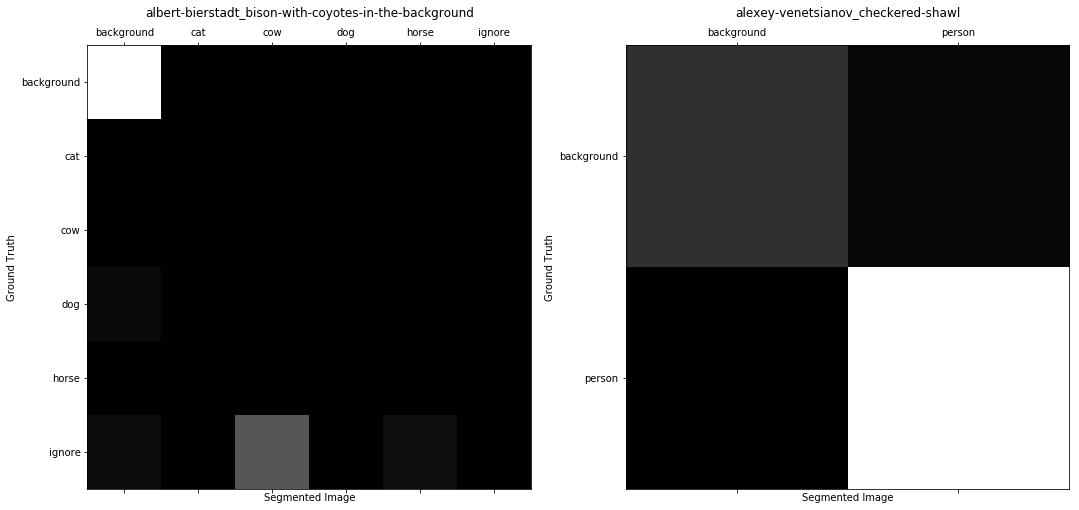

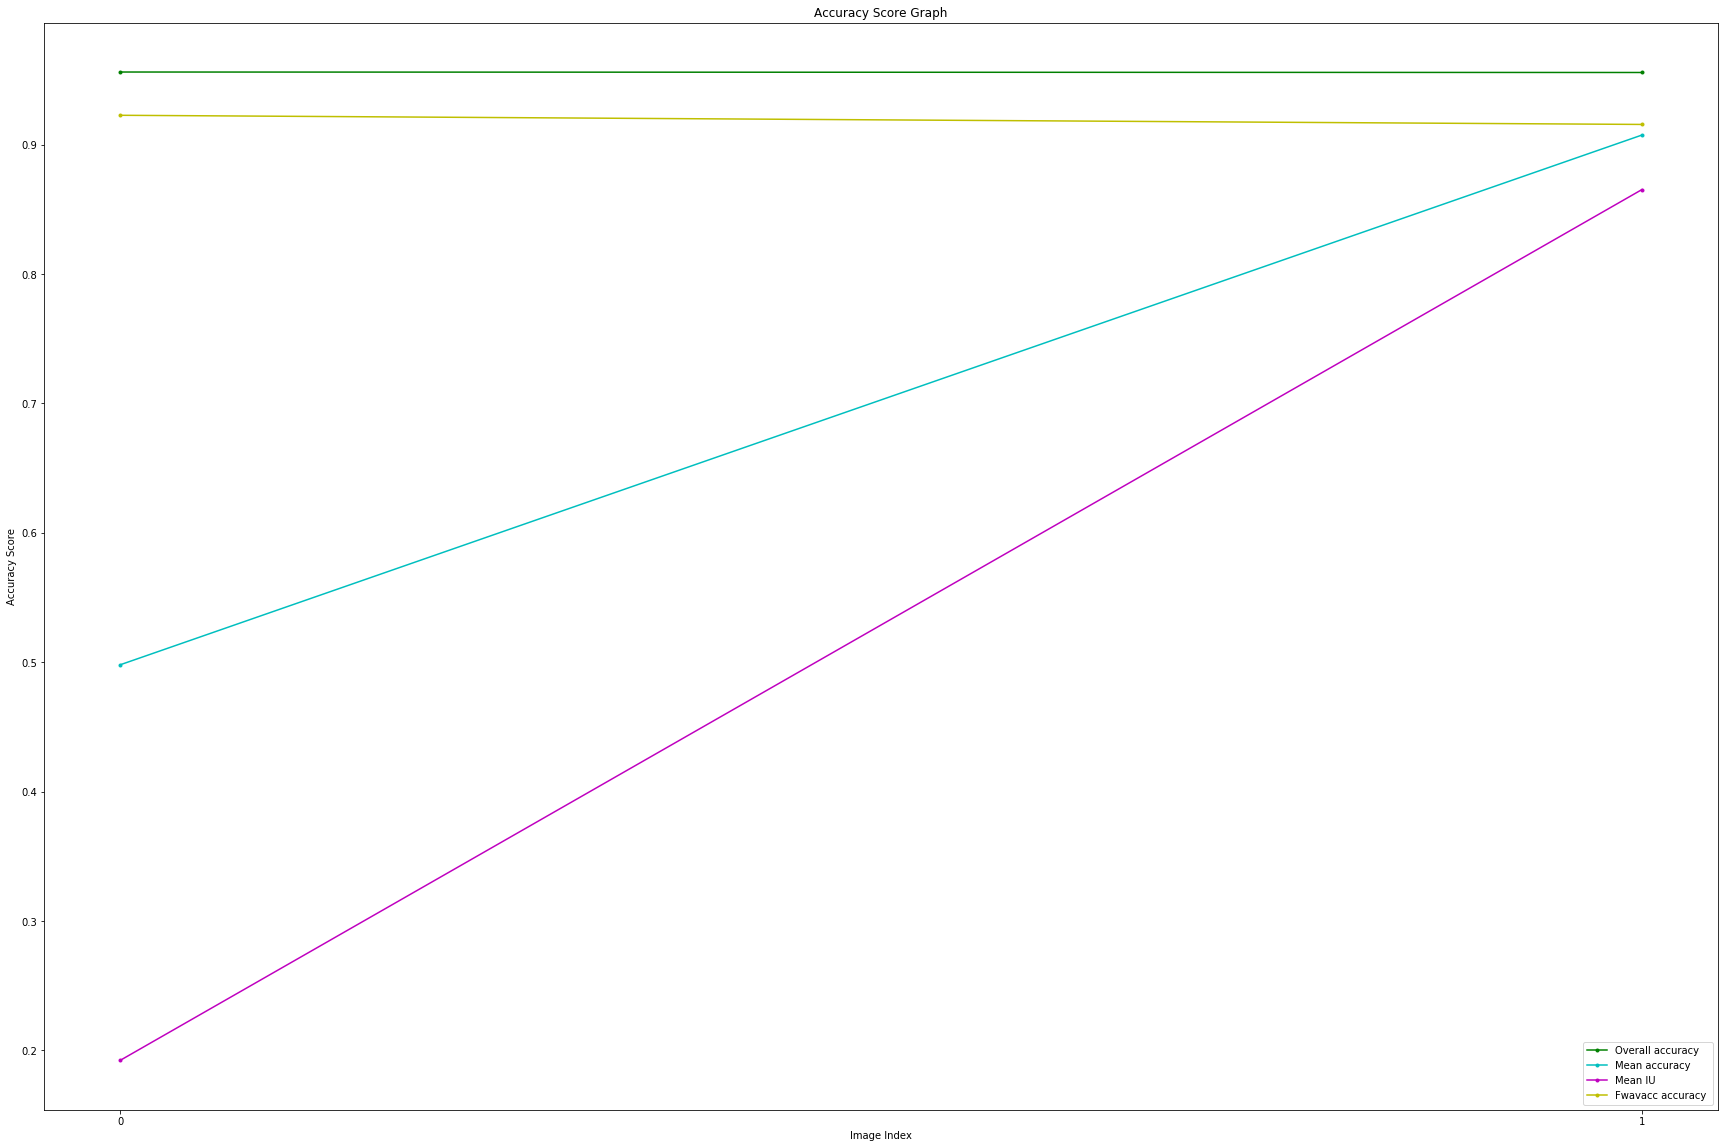

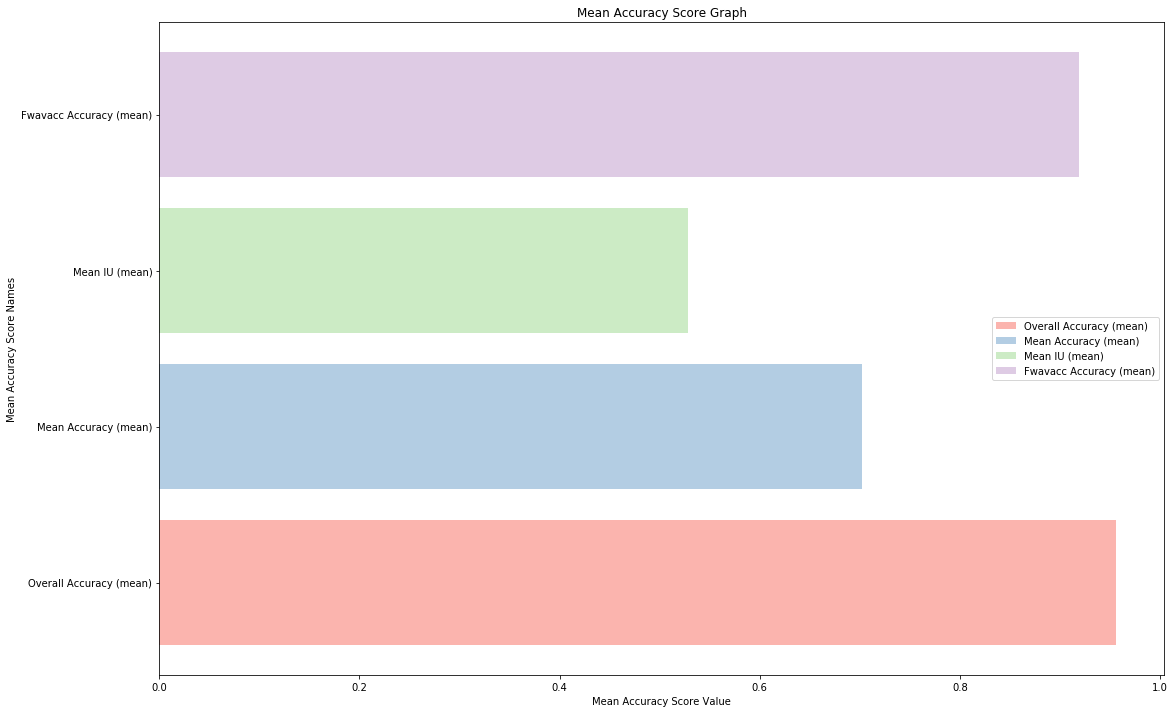

In [33]:
# main process
delimiter = "/"
fp_resume = readResume()

# current painting
current_painting = fp_resume.split("/")
current_painting = current_painting[len(current_painting) - 1].rstrip() # rstrip() for removing white spaces and new line instances

# paintings_path
paintings_path = fp_resume.split("/")
paintings_path.remove(paintings_path[len(paintings_path) - 1])
paintings_path = delimiter.join(paintings_path)

# labels_path
labels_path = fp_resume.split("/")
labels_path.remove(labels_path[len(labels_path) - 1])
labels_path.remove(labels_path[len(labels_path) - 1])
labels_path.append("SegmentationClassPNG")
labels_path = delimiter.join(labels_path)

paintings = getPaintings(paintings_path)
# print(paintings)
# write the paintings list to a text file
lop_f = "demo/list_of_paintings.txt"
with open(lop_f, "r+") as file:
    delayPrint("Writing list of paintings to {}".format(lop_f), PRINT_SECONDS)
    file.write(paintings)

loop(paintings_path, labels_path, paintings, current_painting)